# Analyzing droplet coalescence to determinary capillary velocities

In this Notebook we'll look at how movies of liquid droplets merging (coalescing) can be analyzed to give us the capillary velocity. The values we obtain with our model systems can be compared to values of *in vivo* capillary velocities. 

The methods we'll use are taken from methods described in the paper Elbaum-Garfinkle, S. et al. The disordered P granule protein LAF-1 drives phase separation into droplets with tunable viscosity and dynamics. *PNAS* 112, 7189–7194 (2015). You can find the paper [here](http://www.pnas.org/content/112/23/7189.long).

Figure 2 in that paper highlights the methods. Basically, we measure the long and short axis of two droplets merging. Then we plot the aspect ratio versus time and from that determine a characteristic decay time. The slope of that decay time versus the droplet radius will give us the inverse capillary time. See the figure here
![Fig 2 from Elbaum-Garfinkle et al](Elbaun-Garfinkle_2015_Fig2.gif "Figure 2")


In [91]:
%matplotlib inline
#import mpld3 #need to install with "pip install mpld3"
#mpld3.enable_notebook()
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

import time
import sys
import glob


import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

"""
Using IPython File Upload: 
https://github.com/peteut/ipython-file-upload
pip install fileupload
jupyter nbextension install --py fileupload
jupyter nbextension enable --py fileupload
"""
import io
from IPython.display import display
import fileupload

import pickle
import scipy
from scipy.optimize import leastsq

Below is a montage of three images (each separated by about 0.2 seconds) of two droplets coalescing. The images were acquired using a 10x objective with DIC on the Nikon microscope in ST148. ![Coalescence](Montage_01_3consecutiveframes2.png "Coalescence")

After acquiring the images, load them into ImageJ. We'll use ImageJ to measure the size of the droplets. Measure both the long and short axes (can measure two short axes if the two droplets merging are of unequal size). These measurements can be done using the "line" tool and the *Measure* command (under *Analyze*). In ImageJ's results window go to Results->Options and make sure data is saved as .csv file. That can be loaded into Python with the NumPy function <code>loadtxt</code>.

In [92]:
#Directory to find the data
data_directory = "Z:\\381W\\Fall2017_381W\\TestingData\\2017-08-16_0816rm03\\10x_CoalescenceEvents\\"

#Load the data which has been saved as csv (comma separated values) files. 
#We use "skiprows=1" because the first row is just text describing the columns
results_long = np.loadtxt(data_directory+'01_results_long.csv', delimiter=',', skiprows=1)
results_short = np.loadtxt(data_directory+'01_results_short.csv', delimiter=',', skiprows=1)
drop_diameter_long = results_long[:,-1] #Length of line is last column

#Find aspect ratio
aspect_ratio = results_long[:,-1] / results_short[:,-1]

#Frame rate video was recorded at
frames_per_second = 5.56
times = np.arange(0,len(aspect_ratio))/frames_per_second #time points of data

Let's first just plot the data to see what we have.

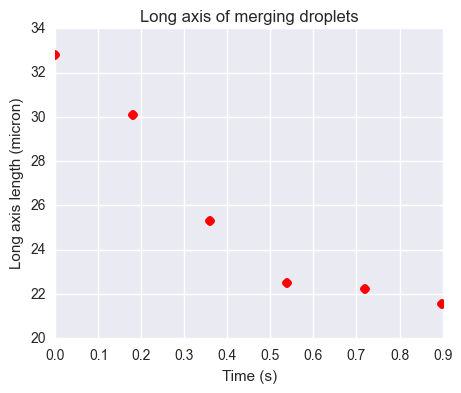

In [93]:
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(times, drop_diameter_long,'ro')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Long axis length (micron)")
ax.set_title("Long axis of merging droplets")

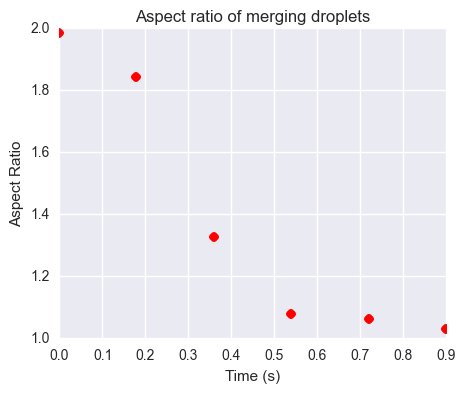

In [94]:
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(times, aspect_ratio,'ro')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Aspect Ratio")
ax.set_title("Aspect ratio of merging droplets")

We'll use a phenomenological model for the aspect ratio of the coalescing droplets. The function below takes four arguments. Those are:
* Amplitude, A
* Characteristic decay time, tau
* Time offset (since coalescence probably not starting exactly at t=0), t_offset
* Time, t

We are using <code>lambda</code> to quickly define a function. You can read more about how to use this way of constructing functions [here](http://zetcode.com/python/lambda/) or just [google it](https://www.google.com/search?q=python+lambda). 

In [95]:
expDecayFunc = lambda A,tau,t_offset,t: 1+A*np.exp(-(t-t_offset)/tau) #Theorectical model for aspect ratio

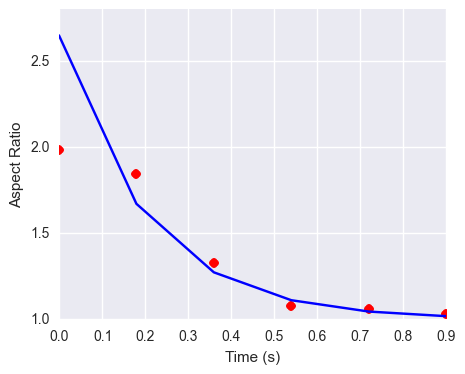

In [96]:
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(times, aspect_ratio,'ro') #Plotting experimental data
ax.plot(times, expDecayFunc(1,0.2,0.1,times),'-b') #Guessing the initial parameters and plotting line
ax.set_xlabel("Time (s)")
ax.set_ylabel("Aspect Ratio")

Below we will create a function that returns the *difference* (aka error) between the theoretical model and the data. This error function is required when we use SciPy's <code>leastsq</code> function which you can read all about [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html). 

In [97]:
errorFunc = lambda params,data,t: data-expDecayFunc(params[0],params[1],params[2],t)

In [98]:
initialGuess = np.array([1,0.2,0.1])
fitResults, flag = leastsq(errorFunc, initialGuess, args=(aspect_ratio[1:],times[1:]))
#Notice that the fitting is excluding the first data point!
print "Best fit decay time: %.2f" % fitResults[1]

Best fit decay time: 0.18


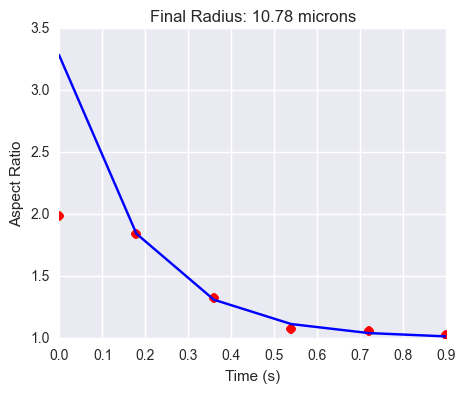

In [99]:
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(times, aspect_ratio,'ro') #Plotting experimental data
ax.plot(times, expDecayFunc(fitResults[0],fitResults[1],fitResults[2],times),'-b') #Plotting final fit results
ax.set_xlabel("Time (s)")
ax.set_ylabel("Aspect Ratio")
ax.set_title("Final Radius: %.2f microns" % (drop_diameter_long[-1]/2))

Best fit decay time: 0.08


(0.9, 2.2)

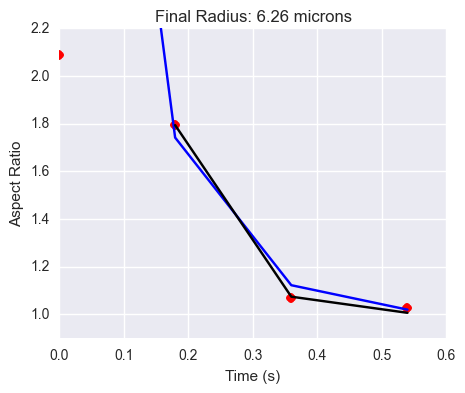

In [100]:
data_directory = "Z:\\381W\\Fall2017_381W\\TestingData\\2017-08-16_0816rm03\\10x_CoalescenceEvents\\"
results_long = np.loadtxt(data_directory+'02_results_long.csv', delimiter=',', skiprows=1)
results_shortL = np.loadtxt(data_directory+'02_results_short_left.csv', delimiter=',', skiprows=1)
results_shortR = np.loadtxt(data_directory+'02_results_short_right.csv', delimiter=',', skiprows=1)
drop_diameter_long = results_long[:,-1] #Length of line is last column
aspect_ratioR = results_long[:,-1] / results_shortR[:,-1]
aspect_ratioL = results_long[:,-1] / results_shortL[:,-1]
aspect_ratio = 0.5*(aspect_ratioL+aspect_ratioR)
frames_per_second = 5.56
times = np.arange(0,len(aspect_ratio))/frames_per_second

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(times, aspect_ratio,'ro') #Plotting experimental data
ax.plot(times, expDecayFunc(1,0.1,0.15,times),'-b') #Guessing the initial parameters and plotting line
ax.set_xlabel("Time (s)")
ax.set_ylabel("Aspect Ratio")
ax.set_title("Final Radius: %.2f microns" % (drop_diameter_long[-1]/2.0))

initialGuess = np.array([1,0.2,0.1])
fitResults, flag = leastsq(errorFunc, initialGuess, args=(aspect_ratio[1:],times[1:]))
#Notice that the fitting is excluding the first data point!
print "Best fit decay time: %.2f" % fitResults[1]
ax.plot(times[1:], expDecayFunc(fitResults[0],fitResults[1],fitResults[2],times[1:]),'-k') #Plotting final fit results
ax.set_ylim(0.9,2.2)

Above, we have analyzed two different coalescence events. So we have the characteristic time for each and the radii of the resulting droplet for each. We'll plot those values and fit that to a line. The slope of that line is equal to the inverse of the capillary velocity. 

*Note*: It should go without saying that two data points are not enough and that you should collect **more**. 

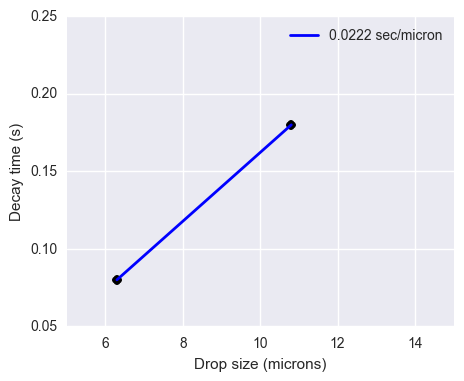

In [101]:
decay_times = np.array([0.18, 0.08])
drop_radii = np.array([10.8, 6.3])
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(drop_radii, decay_times, 'ko')
line_fit = np.polyfit(drop_radii, decay_times, 1)
ax.plot(drop_radii, np.polyval(line_fit, drop_radii),'-b',lw=2,label='%.4f sec/micron' % line_fit[0])
ax.set_xlabel("Drop size (microns)")
ax.set_ylabel("Decay time (s)")
ax.set_xlim(5,15)
ax.set_ylim(0.05,0.25)
ax.legend(loc=0)
